# 4 Pre-Processing Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Introduction<a id='4.2_Introduction'></a>

In preceding notebooks, we performed preliminary assessments of data quality and refined the question to be answered. We determined that predicting market rent is the primary aim. That market rent can be applied to a Return-on-Investment calculation for each house for sale, determining whether or not that house would make a good investment on some ROI threshold. 

Before we can develop a predictive model, we need to encode categoricals, scale, and reduce dimensionality.

## 4.2 Imports<a id='4.3_Imports'></a>

In [326]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.compose import ColumnTransformer
import datetime
import math

from library.sb_utils import save_file

## 4.3 Load Data<a id='4.4_Load_Data'></a>

In [327]:
corporate_data = pd.read_csv('../data/corporate_properties_values_Demo.csv')
corporate_data.head().T

,0,1,2,3,4
property_code,10000753,10000801,10000898,10000946,10001199
address,10627 Kittredge St,10705 Clermont St,10874 Fairfax Way,10944 Bellaire Way,11120 Sylvan Pl
city,Commerce City,Thornton,Thornton,Thornton,Parker
state,CO,CO,CO,CO,CO
zipcode,80022,80233,80233,80233,80138
beds,3,3,4,4,3
baths,2.5,2.0,2.0,2.0,2.0
sqft,1993,1544,1904,1800,1387
market_rent,2939.0,2529.0,2599.0,2485.0,2549.0
lat,39.88982,39.89058,39.89348,39.89548,39.51228


In [328]:
corporate_data.shape

(170, 22)

In [329]:
sale_data = pd.read_csv('../data/for_sale_Demo.csv')
sale_data.head().T

,0,1,2,3,4
address,5211 Willow Way,3547 S Ivanhoe Street,1128 S Jackson Street,2585 N Holly Street,1193 S Clarkson Street
city,Denver,Denver,Denver,Denver,Denver
zip,80238,80237,80210,80207,80210
beds,4.0,5.0,2.0,4.0,4.0
baths,4.0,4.0,2.0,2.0,2.0
sqft,2773,3269,1595,1795,2177
listPrice,750000,750000,750000,750000,750000
taxes,5431,2919,2935,2877,3038
lat,39.792285,39.651669,39.696093,39.754414,39.694933
lng,-104.886263,-104.922119,-104.943268,-104.922607,-104.978287


## 4.4 Manipulate Categorical Data <a id='4.5_Extract_Big_Mountain_Data'></a>

Let's start with the corporate owned properties. 
All of the properties are in Colorado, the state column doesn't add any information, let's remove it. The property_code is a unique, discrete piece of information used only by the property owner, with no relationship to the dependent variable, so let's remove that too. 

In [330]:
# Drop uninformative 'state' and 'property_code' columns
corporate_data = corporate_data.drop(['state', 'property_code'], axis=1)

Let's rename a couple of features so they make sense across dataframes. Rename 'districtMatch' to 'district', and 'estimatedValue' to 'value'. We will do the same on the other dataframe once we begin pre-processing it. 

In [331]:
# Rename two columns in corporate data df
cols = {'districtMatch':'district', 'estimatedValue':'value'}
corporate_data = corporate_data.rename(columns=cols)

In [332]:
# rename sale_data columns
cols={'zip':'zipcode', 'listPrice':'value', 'districtMatch':'district'}
sale_data = sale_data.rename(columns=cols)

The 'city' column doesn't add any information. Instead, let's use some information to categorize the cities by household income. Data for 2019 is available on the US Census site. Import that data, add to both the corporate_data and sale_data records, and we will set aside the city column before doing the test/train split. 

Additionally, the *name* of the district doesn't add any information. For each district, we have already gathered some information on the school lunch program (an indicator of poverty in the community), the rank of the schools within the district, and the racial demographics.

In [333]:
income = pd.read_csv('../data/City income.csv')
income_T = income.T

In [334]:
new_header = income_T.iloc[0] 
# take the rest of the data minus the header row
income_T = income_T[1:] 
# set the header row as the df header
income_T.columns = new_header 
income_T.rename(columns = {'Fact ':'City'}, inplace = True)

In [335]:
income_T.columns

Index(['Median household income (in 2019 dollars), 2015-2019', 'Per capita income in past 12 months (in 2019 dollars), 2015-2019'], dtype='object', name='Fact')

In [336]:
income_T.drop(['Per capita income in past 12 months (in 2019 dollars), 2015-2019'], axis=1, inplace=True)

In [337]:
# Let's see if there are any towns in the corporate_data set which are not included in the income data. 
no_data = corporate_data[~corporate_data['city'].isin(income_T.index)]
no_data.head()

,address,city,zipcode,beds,baths,sqft,market_rent,lat,lng,district,value,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,percentofWhiteStudents,rankMovement
6,11375 Nome St,Henderson,80640,4,2.0,2087,2595.0,39.90208,-104.85186,Brighton 27J School District,471589.95,44.03,2.20,2.92,53.74,0.31,0.17,3.00,37.65,-48.06
59,11620 Oakland Dr,Henderson,80640,3,1.5,1420,2339.0,39.90825,-104.84968,Brighton 27J School District,425300.00,44.03,2.20,2.92,53.74,0.31,0.17,3.00,37.65,-48.06
97,11798 W Marlowe Ave,Morrison,80465,4,2.5,2404,2933.0,39.63200,-105.12900,Jefferson County R-1 School District,430457.50,37.16,1.45,2.89,26.14,0.62,0.14,4.07,64.70,-23.29


The houses in Henderson are actually in Commerce City. This is a quirk of Denver-metro addresses. Morrison is a tiny area, so there isn't any data available for it. The closest town to Morrison is Golden. Let's map these in both the corporate and sales data. 

In [338]:
dict1 = {'Henderson':'Commerce City', 'Morrison':'Golden'}
corporate_data.loc[corporate_data['city'].isin(dict1.keys()), 'city'] = corporate_data['city'].map(dict1)

In [339]:
# Let's see if there is any sales data that doesn't have income information. 
no_data = sale_data[~sale_data['city'].isin(income_T.index)]

In [340]:
no_data['city'].unique()

array(['Morrison', 'Indian Hills', 'Idledale'], dtype=object)

All of these little hamlets are near Golden, so let's map them to Golden. 

In [341]:
dict2={'Morrison':'Golden', 'Indian Hills':'Golden', 'Idledale':'Golden'}
sale_data.loc[sale_data['city'].isin(dict1.keys()), 'city'] = sale_data['city'].map(dict1)

In [342]:
corporate_data_I = corporate_data.merge(income_T, left_on='city', right_on=income_T.index)
corporate_data_I.shape, corporate_data.shape

((170, 21), (170, 20))

In [343]:
sale_data_I = sale_data.merge(income_T, left_on='city', right_on=income_T.index)

We have a problem with the HOA data. Some of the deployment data (houses for sale) have HOAs, but we don't have any information about whether the corporate properties have an HOA. So, we have no way to scale that data.
One idea is to combine the HOA price into the value of the house, over 30 years. Let's do that with the sales_data. 

In [344]:
sale_data_I['value'] = sale_data_I['value'] + (sale_data_I['monthly_hoa'] * 12)
sale_data_I.drop(['monthly_hoa'], axis=1, inplace=True)

We have taxes for the sale data, because it is included in the listing. But, it is linearly related to the value of the house, because it is a percentage of the house's value. Therefore, instead of *adding* tax data for the corporate-owned houses, we shall remove the tax data from the sale houses. 

In [345]:
# drop tax column because it's linearly related to sales price (percentage of sales price)
sale_data_I.drop('taxes', axis=1, inplace=True)

'Beds' and 'baths' should be categorical columns, since these are inherently categorical. Change the data types of these columns.

In [346]:
corporate_data_I['beds'] = pd.Categorical(corporate_data_I.beds)
corporate_data_I['baths'] = pd.Categorical(corporate_data_I.baths)
sale_data_I['beds'] = pd.Categorical(sale_data_I.beds)
sale_data_I['baths'] = pd.Categorical(sale_data_I.baths)

In [347]:
sale_data_I.columns, corporate_data_I.columns

(Index(['address', 'city', 'zipcode', 'beds', 'baths', 'sqft', 'value', 'lat',
        'lng', 'district', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement',
        'Median household income (in 2019 dollars), 2015-2019'],
       dtype='object'),
 Index(['address', 'city', 'zipcode', 'beds', 'baths', 'sqft', 'market_rent',
        'lat', 'lng', 'district', 'value', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement',
        'Median household income (in 2019 dollars), 2015-2019'],
       dtype='object'))

In [348]:
# Re-order corporate_data columns. 
corporate_data_I = corporate_data_I.loc[:, ['address', 'city', 'zipcode', 'beds', 'baths', 'sqft', 'market_rent',
                                        'value', 'lat', 'lng', 'district', 'percentFreeDiscLunch',
                                        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
                                        'percentofHispanicStudents', 'percentofIndianStudents',
                                        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
                                        'percentofWhiteStudents', 'rankMovement', 
                                        'Median household income (in 2019 dollars), 2015-2019']]


In [349]:
# Check datatype of new column
corporate_data_I['Median household income (in 2019 dollars), 2015-2019'].dtypes

dtype('O')

In [350]:
corporate_data_I[['Median household income (in 2019 dollars), 2015-2019']] = \
        corporate_data_I[['Median household income (in 2019 dollars), 2015-2019']].replace('[\$,]','',regex=True).astype(float)

In [351]:
sale_data_I[['Median household income (in 2019 dollars), 2015-2019']] = \
        sale_data_I[['Median household income (in 2019 dollars), 2015-2019']].replace('[\$,]','',regex=True).astype(float)

## 4.5 Train/Test Split<a id='4.6_Train/Test_Split'></a>

Let's use a 70/30 train/test split within the corporate data, using 'market_rent' as the dependent variable. 

In [352]:
# use train_test_split 
X_train, X_test, y_train, y_test = train_test_split(corporate_data_I.drop(columns='market_rent'), 
                                                    corporate_data_I.market_rent, test_size=0.05, 
                                                    random_state=42)

In [353]:
X_train.shape, X_test.shape

((161, 20), (9, 20))

In [354]:
y_train.shape, y_test.shape

((161,), (9,))

In [355]:
#Save the 'address' and 'zipcode' columns from the train/test data into address_train
# and address_train
#Then drop those columns from `X_train` and `X_test`. Use 'inplace=True'
address_list = ['address', 'zipcode', 'lat', 'lng', 'district', 'city']
address_train = X_train[address_list]
address_test = X_test[address_list]
X_train.drop(columns=address_list, inplace=True)
X_test.drop(columns=address_list, inplace=True)
X_train.shape, X_test.shape

((161, 14), (9, 14))

In [356]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

beds                                                    category
baths                                                   category
sqft                                                       int64
value                                                    float64
percentFreeDiscLunch                                     float64
percentofAfricanAmericanStudents                         float64
percentofAsianStudents                                   float64
percentofHispanicStudents                                float64
percentofIndianStudents                                  float64
percentofPacificIslanderStudents                         float64
percentofTwoOrMoreRaceStudents                           float64
percentofWhiteStudents                                   float64
rankMovement                                             float64
Median household income (in 2019 dollars), 2015-2019     float64
dtype: object

In [357]:
#Repeat this check for the test split in `X_test`
X_test.dtypes

beds                                                    category
baths                                                   category
sqft                                                       int64
value                                                    float64
percentFreeDiscLunch                                     float64
percentofAfricanAmericanStudents                         float64
percentofAsianStudents                                   float64
percentofHispanicStudents                                float64
percentofIndianStudents                                  float64
percentofPacificIslanderStudents                         float64
percentofTwoOrMoreRaceStudents                           float64
percentofWhiteStudents                                   float64
rankMovement                                             float64
Median household income (in 2019 dollars), 2015-2019     float64
dtype: object

All features in X are numeric.

## 4.6 Scale Data <a id='4.5_Extract_Big_Mountain_Data'></a>

 Let's look at the distributions of the training data. 

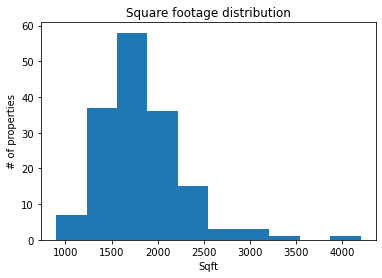

In [358]:
plt.hist(X_train['sqft'])
plt.title('Square footage distribution')
plt.xlabel('Sqft')
plt.ylabel('# of properties')
plt.show()

It looks like the outliers may be skewing the data. We will remove the top 3% of square footage data:

In [359]:
# Make a mask to trim off top 3% of square footage
q_cutoff = X_train['sqft'].quantile(0.97)
mask = X_train['sqft'] < q_cutoff
tr_X_train = X_train[mask]
tr_y_train = y_train[mask]

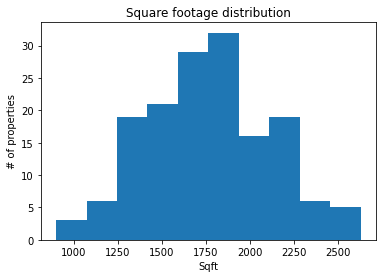

In [360]:
# Recheck the sqft distribution
plt.hist(tr_X_train['sqft'])
plt.title('Square footage distribution')
plt.xlabel('Sqft')
plt.ylabel('# of properties')
plt.show()

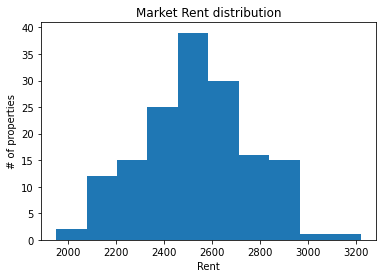

In [361]:
plt.hist(tr_y_train)
plt.title('Market Rent distribution')
plt.xlabel('Rent')
plt.ylabel('# of properties')
plt.show()

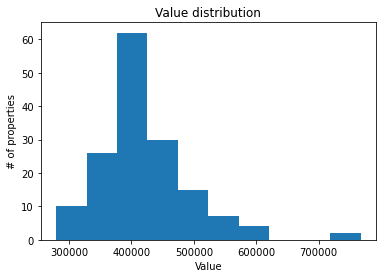

In [362]:
plt.hist(tr_X_train['value'])
plt.title('Value distribution')
plt.xlabel('Value')
plt.ylabel('# of properties')
plt.show()

These histograms look pretty normal. We can use Min-Max Scaling on the value, market_rent, and sqft features. Let's see if the mins/max are fairly similar between both the test and train sets. 

In [364]:
tr_X_train['sqft'].max(), X_test['sqft'].max(), tr_X_train['sqft'].min(), X_test['sqft'].min()

(2626, 2645, 900, 1650)

Those values are too different, we cannot use Min Max Scaling. Let's use Standard Scaler instead on square footage and value. 

In [365]:
# create a copy of df
scaled_tr_X_train = tr_X_train.copy()
# create list of columns to be transformed
colnames = ['value', 'sqft', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement', 'Median household income (in 2019 dollars), 2015-2019']
features = scaled_tr_X_train[colnames]
valSqftscaler = StandardScaler().fit(features.values)
features = valSqftscaler.transform(features.values)

In [366]:
scaled_tr_X_train[colnames] = features
scaled_tr_X_train.shape

(156, 14)

In [367]:
scaled_tr_X_train.columns

Index(['beds', 'baths', 'sqft', 'value', 'percentFreeDiscLunch',
       'percentofAfricanAmericanStudents', 'percentofAsianStudents',
       'percentofHispanicStudents', 'percentofIndianStudents',
       'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
       'percentofWhiteStudents', 'rankMovement',
       'Median household income (in 2019 dollars), 2015-2019'],
      dtype='object')

In [368]:
# In case I want to transform x, y, z
#scaled_tr_X_train['x'] = math.sin
#scaled_tr_X_train['y'] = 
#scaled_tr_X_train['z'] = 
#  x = r * math.sin(theta) * math.cos(phi) # bronstein (3.381a)
#    y = r * math.sin(theta) * math.sin(phi)
#    z = r * math.cos(theta)

The X_train data is now transformed. Let's look at it:

In [372]:
scaled_tr_X_train.describe()

,sqft,value,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,percentofWhiteStudents,rankMovement,"Median household income (in 2019 dollars), 2015-2019"
count,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02
mean,3.031763e-16,2.683039e-16,3.835963e-16,-9.821204e-17,1.594166e-16,-1.708035e-16,-2.843167e-16,-8.219920e-17,5.835788e-17,-3.366253e-16,2.633221e-17,1.081756e-16
std,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00,1.003221e+00
min,-2.464458e+00,-1.946024e+00,-1.647811e+00,-1.117975e+00,-1.662641e+00,-1.426565e+00,-3.038359e+00,-8.871405e-01,-1.791030e+00,-1.626091e+00,-1.479552e+00,-7.253852e-01
25%,-7.296377e-01,-5.612758e-01,-6.519587e-01,-1.021750e+00,-9.969505e-01,-9.421409e-01,-2.971690e-01,-6.746937e-01,-7.714134e-01,-7.962618e-01,-6.116763e-01,-7.253852e-01
50%,-3.230801e-02,-9.406919e-02,-7.819268e-02,5.836765e-01,-1.220432e-01,4.940095e-01,-5.529927e-02,-3.104992e-01,2.482031e-01,-2.703255e-02,-3.091199e-01,-5.179478e-01
75%,6.621870e-01,3.632037e-01,8.702593e-01,7.913185e-01,1.394780e-01,8.600898e-01,9.928028e-01,1.143944e-01,4.490366e-01,5.435362e-01,8.502467e-02,1.247400e-01
max,2.428188e+00,4.726258e+00,1.570425e+00,1.496964e+00,1.684831e+00,2.025719e+00,1.234672e+00,2.147814e+00,1.535598e+00,1.815892e+00,2.301456e+00,2.859861e+00


In [370]:
scaled_tr_X_train.shape

(156, 14)

## 4.8 Transformation of test data <a id='4.6_Train/Test_Split'></a>

First, let's use the previously fit scaling tool to scale the test data. 

In [373]:
# create a copy of df
scaled_X_test = X_test.copy()
# create list of columns to be transformed
colnames = ['value', 'sqft', 'percentFreeDiscLunch',
        'percentofAfricanAmericanStudents', 'percentofAsianStudents',
        'percentofHispanicStudents', 'percentofIndianStudents',
        'percentofPacificIslanderStudents', 'percentofTwoOrMoreRaceStudents',
        'percentofWhiteStudents', 'rankMovement', 'Median household income (in 2019 dollars), 2015-2019']
features = scaled_X_test[colnames]
features = valSqftscaler.transform(features.values)

In [374]:
scaled_X_test[colnames] = features
scaled_X_test.shape

(9, 14)

Because the StandardScaler() was fit on the training data, the mean of the test data will not be zero. 

In [375]:
scaled_X_test.describe()

,sqft,value,percentFreeDiscLunch,percentofAfricanAmericanStudents,percentofAsianStudents,percentofHispanicStudents,percentofIndianStudents,percentofPacificIslanderStudents,percentofTwoOrMoreRaceStudents,percentofWhiteStudents,rankMovement,"Median household income (in 2019 dollars), 2015-2019"
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.636675,0.131373,-0.326930,-0.211253,0.207632,-0.436665,-0.234462,-0.121658,0.161805,0.433169,0.347647,0.688342
std,0.833306,1.118185,1.139254,1.011236,1.164982,1.157039,1.275261,0.970210,1.195678,1.132100,1.136149,1.350319
min,-0.338453,-2.497256,-1.647811,-1.117975,-0.996951,-1.426565,-3.038359,-0.887140,-1.523252,-1.368052,-0.930655,-0.725385
25%,0.143442,-0.094255,-0.651959,-1.021750,-0.668860,-0.942141,-0.055299,-0.674694,-0.586029,0.369800,-0.309120,-0.517948
50%,0.347538,0.276180,-0.651959,-0.939031,-0.164838,-0.942141,-0.055299,-0.310499,0.248203,0.369800,0.085025,-0.069450
75%,1.064711,0.578454,-0.388324,0.583677,1.684831,-0.658225,0.267194,-0.310499,1.535598,1.064745,0.312416,1.901680
max,2.482047,1.449840,1.570425,1.496964,1.684831,2.025719,1.234672,2.147814,1.535598,1.815892,2.301456,2.509439
